In [35]:
from dataclasses import dataclass
from typing import Dict, Iterable, List

import numpy as np
import numpy.typing as npt
import pandas as pd
from matplotlib import pyplot as plt
from scipy import signal
from skimage.transform import downscale_local_mean


In [36]:
def convert_complex_numbers(frame: pd.DataFrame) -> pd.DataFrame:
    """
    Convert complex numbers strings where 'i' (Math convention) is used to use 'j' (Engineering convention) instead
    and convert it to numpy complex number type.
    :param frame: A Pandas dataframe
    :return: A data frame containing numpy complex numbers.
    """
    return frame.map(lambda row: np.csingle(row.replace("i", "j")))[0]


# Read the data where b = Bluetooth, w = WiFi, z = Zigbee. So the frame
# called 'zb' means it is the spectrogram containing Zigbee and Bluetooth
# signals.
data_frames: Dict[str, pd.DataFrame] = {
    "b": pd.read_csv("data/csv/B_SNR30.csv", sep=",", header=None, dtype=str),
    "bw": pd.read_csv("data/csv/BW_SNR30.csv", sep=",", header=None, dtype=str),
    "w": pd.read_csv("data/csv/W_SNR30.csv", sep=",", header=None, dtype=str),
    "z": pd.read_csv("data/csv/Z_SNR30.csv", sep=",", header=None, dtype=str),
    "zb": pd.read_csv("data/csv/ZB_SNR30.csv", sep=",", header=None, dtype=str),
    "zw": pd.read_csv("data/csv/ZW_SNR30.csv", sep=",", header=None, dtype=str),
    "zbw": pd.read_csv("data/csv/ZBW_SNR30.csv", sep=",", header=None, dtype=str)
}

# Convert complex number notation
data_frames = {key: convert_complex_numbers(frame) for key, frame in data_frames.items()}

In [37]:
@dataclass
class Spectrogram:
    """
    This stores the information required to interpret a spectrogram.
    
    f are the frequencies
    t are an array of time intervals
    values is a 2D numpy array for the magnitudes for each frequency f at time t.
    """
    f: [int]
    t: [int]
    values: npt.NDArray[float]


In [38]:
def plot_spectrogram(spectrogram: Spectrogram):
    plt.pcolormesh(spectrogram.f, spectrogram.t, spectrogram.values.T, shading="nearest")
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Time (s)")
    plt.title("Spectrogram")
    plt.colorbar(label="Magnitude (dB)")
    plt.show()

In [39]:
# Sampling frequency
fs = 20000000  # Hz


def move_front_half_to_end(array: npt.NDArray) -> npt.NDArray:
    """
    Move the front half of an array to the end
    """
    n = len(array)
    return np.concatenate((array[n // 2:], array[:n // 2]))


def create_spectrogram(x: Iterable) -> Spectrogram:
    """
    Create a spectrogram of a signal.
    :param x: The signal
    :return: A Spectrogram instance that contains the frequencies, time and values.
    """

    # Calculate Short Time Fourier Transform of the signal.
    # return_one_sided is needed because the data is complex
    f, t, Zxx = signal.stft(x=x, fs=fs, return_onesided=False)

    # A spectrogram is the absolute value of the STFT and then squared.
    Zxx_abs = (np.abs(Zxx) ** 2)

    # For some reason our spectrogram has the negative frequencies in
    # the *last* half of the data so this method moves to the front
    # This can help with plotting because to use 'nearest' shading requires the 
    # data to be monotonically increasing/decreasing in value. 
    return Spectrogram(move_front_half_to_end(f), t, move_front_half_to_end(Zxx_abs))


spectrograms = {key: create_spectrogram(frame) for key, frame in data_frames.items()}


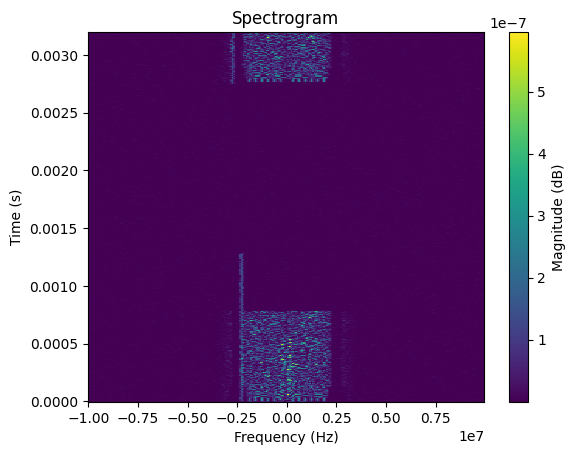

In [40]:
def split_spectrogram(spectrogram: Spectrogram, duration: int) -> List[Spectrogram]:
    """
    Split up a spectrogram along the time axis into a bunch of smaller spectrograms. 
    :param spectrogram: The spectrogram to split
    :param duration: The length of each sub-spectrogram
    :return: 
    """
    sub_spectrograms: [Spectrogram] = []

    start_index: int = 0
    end_index: int = duration

    while end_index < len(spectrogram.t):
        values_slice = [time_values[start_index:end_index] for time_values in spectrogram.values]

        sub_spectrograms.append(
            Spectrogram(spectrogram.f,
                        spectrogram.t[start_index:end_index],
                        np.array(values_slice)))

        start_index += duration
        end_index += duration

    return sub_spectrograms


# How long a spectrogram for one training image should be. This is the number of rows
# in the spectrogram array.
training_spec_duration = 500

split_spectrograms = split_spectrogram(spectrograms["zbw"], training_spec_duration)

plot_spectrogram(split_spectrograms[0])

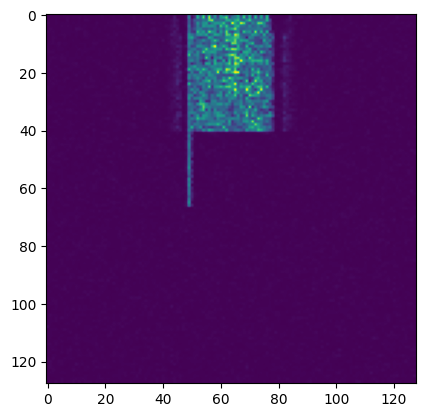

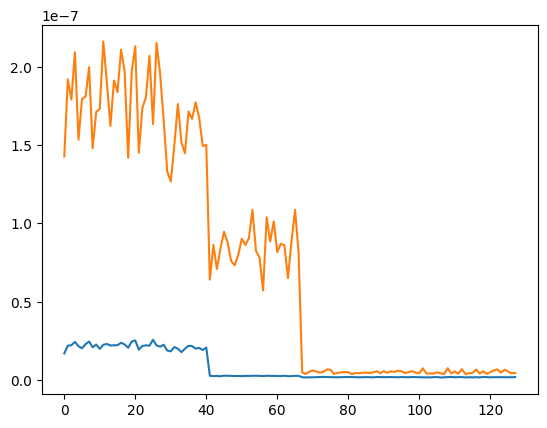

In [41]:
def downsample(spectrogram: npt.NDArray[float], resolution: int) -> npt.NDArray:
    """
    Downsample a spectrogram to a target N x N resolution.
    
    :param spectrogram: A 2D array of a spectrogram. 
    :arg resolution: The target height/width of the image in pixels.
    :return: The downsampled spectrogram.
    """

    (height, width) = spectrogram.shape
    time_factor = width // resolution
    freq_factor = height // resolution
    downsampled_spec_values = downscale_local_mean(spectrogram, (freq_factor, time_factor))[:resolution, :resolution]

    assert downsampled_spec_values.shape == (resolution, resolution)
    return downsampled_spec_values


def augment(spectrogram: npt.NDArray[float], K: int, L: int, D: int) -> npt.NDArray[float]:
    """
    Augment the Bluetooth and Zigbee signals by stretching them.

    :param spectrogram: An M x N array of signal magnitude values. 
    :param K: The number of maximum values
    :param L: The sliding window size
    :param D: The step size
    """

    # copy the spectrogram so modifying the values in-place
    # does not change the argument.
    spectrogram_copy = np.copy(spectrogram).T
    (M, N) = spectrogram_copy.shape

    augmented_width = (N - L) // D + 1
    augmented_spectrogram: np.ndarray = np.zeros(shape=(M, augmented_width), dtype=float)

    m = np.mean(spectrogram_copy)

    for i in range(1, M):
        j_augmented = 0
        j = 0
        while j <= N - L:
            # For the current row i, get a window of size L.
            window = spectrogram_copy[i][j:(j + L)]
            # Get the top K elements by sorting and taking last K elements.
            top_k = np.sort(window)[len(window) - K:]
            mean_top_k = np.mean(top_k)
            spectrogram_copy[i][j] = mean_top_k
            augmented_spectrogram[i][j_augmented] = spectrogram_copy[i][j] - m

            j_augmented += 1
            j += D

    return augmented_spectrogram


def normalize_spectrogram(spectrogram: np.ndarray) -> np.ndarray:
    """
    
    :param spectrogram: 
    :return: 
    """
    scale: float = 1 / spectrogram.max()
    return spectrogram * scale


target_resolution = 128

downsampled_spectrograms = [downsample(spec.values, target_resolution) for spec in split_spectrograms]

plt.imshow(downsampled_spectrograms[0].T)
plt.show()

plt.plot(np.mean(downsampled_spectrograms[0], axis=0))
plt.plot(np.max(downsampled_spectrograms[0], axis=0))
plt.show()

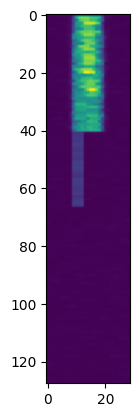

In [42]:
K = 3
L = 16
D = 4

augmented_spectrograms = [augment(spec, K, L, D) for spec in downsampled_spectrograms]

plt.imshow(augmented_spectrograms[0])
plt.show()

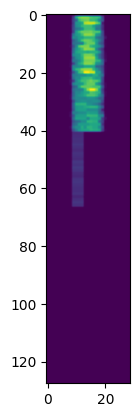

In [49]:
def digitize_spectrogram(spectrogram: npt.NDArray[float], color_depth: int) -> npt.NDArray[int]:
    max_value: float = spectrogram.max()
    scale: float = color_depth / max_value
    spectrogram = spectrogram.clip(0, max_value)
    scaled_spectrogram = spectrogram * scale
    
    bins = np.arange(color_depth, dtype=int)
    bin_indices = np.digitize(scaled_spectrogram, bins)
    return bins[bin_indices - 1]

digitized_spectrograms = [digitize_spectrogram(spec, color_depth=256) for spec in augmented_spectrograms]

plt.imshow(digitized_spectrograms[0])
plt.show()


In [44]:

# The ratio of training data to test data
training_ratio = 0.8

np.random.seed(42)

np.random.shuffle(digitized_spectrograms)

split_index: int = int(training_ratio * len(digitized_spectrograms))

train_spectrograms: List[Spectrogram] = digitized_spectrograms[:split_index]
test_spectrograms: List[Spectrogram] = digitized_spectrograms[split_index:]

print(f"Number of training images: {len(train_spectrograms)}")
print(f"Number of test images: {len(test_spectrograms)}")

Number of training images: 12
Number of test images: 3
